Use the windspharm to extract rotational (non-divegent) componenet from real wind data.

Starting with global wind fields even if we eventually only use region data!
Spherical harmonics requires global field. Extracting rotational component from region data is a research question.
See Partitioning the Wind in a Limited Domain https://journals.ametsoc.org/doi/10.1175/1520-0493%281989%29117%3C1492%3APTWIAL%3E2.0.CO%3B2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from windspharm.xarray import VectorWind

In [2]:
#ds = xr.open_dataset('./GEOSFP.20160701.A3dyn.4x5.nc').isel(time=0, lev=20)
ds = xr.open_dataset('./GEOSFP.20160701.A3dyn.025x03125.nc').isel(time=0, lev=20)

# windspharm requires that "girds with an even number of points do not include the poles (and conversely grids with an odd number of latitude points must include the poles)."
# See https://github.com/ajdawson/windspharm/issues/77#issuecomment-268850740
# GEOS-FP reuse half-polar cell. Might change to uniform latitude first.

ds['lat'].values = np.linspace(-90, 90, ds['lat'].size)
ds['lat']

<xarray.DataArray 'lat' (lat: 721)>
array([-90.  , -89.75, -89.5 , ...,  89.5 ,  89.75,  90.  ])
Coordinates:
    time     datetime64[ns] 2016-07-01T01:30:00
    lev      float32 21.0
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 -89.0 -88.75 -88.5 ...
Attributes:
    long_name:  latitude
    units:      degrees_north

In [3]:
def plot_wind(ds):
    '''Plot u, v and streamline'''
    fig, axes = plt.subplots(1, 3, figsize=[12, 4])

    ds['U'].plot(ax = axes[0], cbar_kwargs={'shrink': 0.9, 'label': 'm/s', 'orientation': 'horizontal'})
    axes[0].set_title('U wind')

    ds['V'].plot(ax = axes[1], cbar_kwargs={'shrink': 0.9, 'label': 'm/s', 'orientation': 'horizontal'})
    axes[1].set_title('V wind')

    axes[2].streamplot(ds['lon'].values, ds['lat'].values, ds['U'].values, ds['V'].values,
                       density=1)
    axes[2].set_title('streamline')

    fig.tight_layout()

CPU times: user 4.28 s, sys: 66.9 ms, total: 4.35 s
Wall time: 3.97 s


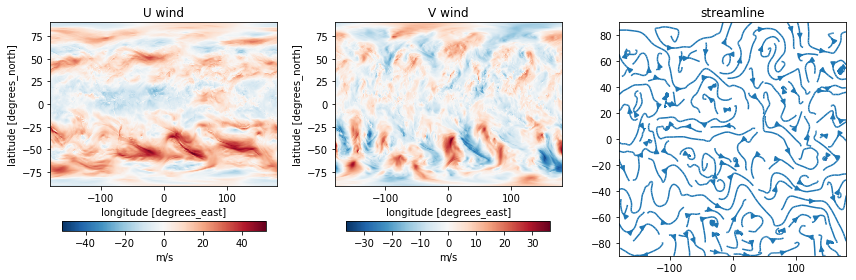

In [4]:
%%time
plot_wind(ds)

## Get divergence and vorticity

In [5]:
%%time
# construct windspharm object
wind = VectorWind(ds['U'], ds['V'])

CPU times: user 4.56 s, sys: 627 ms, total: 5.19 s
Wall time: 5.16 s


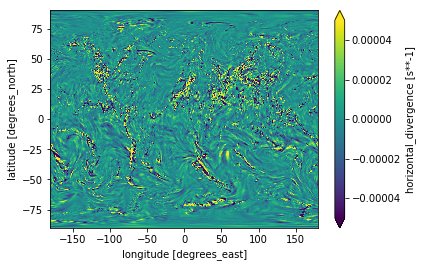

In [6]:
wind.divergence().plot(vmin=-5e-5, vmax=5e-5)

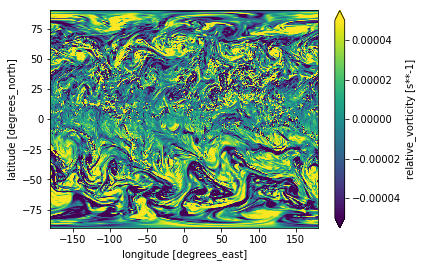

In [7]:
wind.vorticity().plot(vmin=-5e-5, vmax=5e-5)

In [8]:
wind.vorticity().max(), wind.vorticity().min()

(<xarray.DataArray 'vorticity' ()>
 array(0.000656, dtype=float32), <xarray.DataArray 'vorticity' ()>
 array(-0.00059, dtype=float32))

## Remove divergent component

In [9]:
u_psi, v_psi = wind.nondivergentcomponent()

In [10]:
ds_nodiv = xr.merge([u_psi.rename('U'), v_psi.rename('V')])

In [11]:
%%time
wind_nodiv = VectorWind(u_psi, v_psi)

CPU times: user 4.63 s, sys: 606 ms, total: 5.23 s
Wall time: 5.17 s


In [12]:
# divergence almost zero
np.abs(wind_nodiv.divergence()).max()  

<xarray.DataArray 'divergence' ()>
array(1.621001e-08, dtype=float32)

In [13]:
# voriticity unaffected
wind_nodiv.vorticity().max(), wind_nodiv.vorticity().min()

(<xarray.DataArray 'vorticity' ()>
 array(0.000656, dtype=float32), <xarray.DataArray 'vorticity' ()>
 array(-0.00059, dtype=float32))

CPU times: user 3.07 s, sys: 88 ms, total: 3.16 s
Wall time: 3.58 s


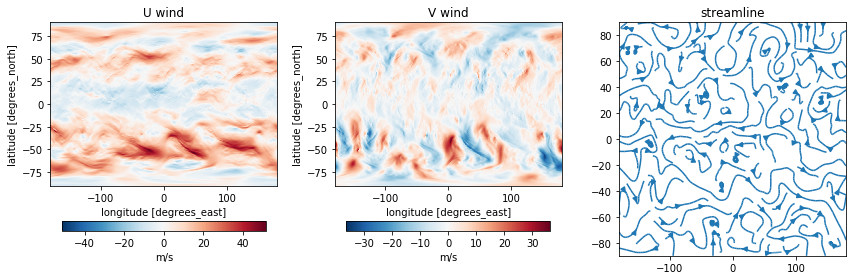

In [14]:
%%time
# Look visually the same as before
plot_wind(ds_nodiv)

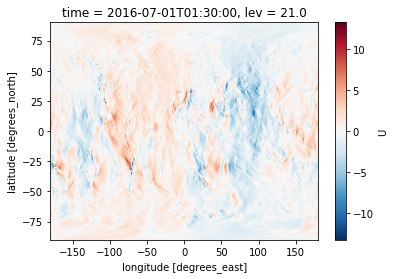

In [15]:
# The actual difference is non-trivial. But good enough for idealized experiments.
(ds_nodiv['U'] - ds['U']).plot()